# 居住/工作位置识别

(1) 居住位置判断规则
* 工作日发生
* 18:00:00~8:00:00
* 次数最多的停驻位置

(2) 工作位置判断规则
* 工作日发生
* 9:00:00~16:00:00
* 17个工作日中至少有12天位于同一位置

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import shapely
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

pd.set_option('max_rows',1000)
pd.set_option('max_columns',50)

os.chdir('E:\\zy城市群数据分析\\190519导出职住数据')

### (0) 栅格对应的数据

In [ ]:
# grid = gpd.read_file('../0栅格数据/栅格-乡镇对应/joinRes.shp')          # 栅格数据，已经与乡镇数据连接起来了
# town = gpd.read_file('../0栅格数据/9市街道区划/9市街道区划-合并.shp')   # 乡镇数据

In [2]:
grid = gpd.read_file('../0栅格数据/栅格-乡镇对应/grid_new.shp')
town = gpd.read_file('../0栅格数据/栅格-乡镇对应/town_new.shp')

In [3]:
grid.head()

,id,LONCOL,LATCOL,HBLON,HBLAT,name,County,City,Province,GridRing,TownRing,geometry
0,0,0,281,118.357348,31.931298,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.36 31.92904945779842, 118.354695..."
1,1,0,282,118.357348,31.935794,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.36 31.93354606300484, 118.354695..."
2,2,0,283,118.357348,31.940291,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.36 31.93804266821126, 118.354695..."
3,3,1,281,118.362652,31.931298,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.3653043927706 31.92904945779842,..."
4,4,1,282,118.362652,31.935794,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.3653043927706 31.93354606300484,..."


In [4]:
town.head()

,name,Province,City,County,label,TownRing,geometry
0,嘉定工业区,上海市,上海市,嘉定区,嘉定工业区|嘉定区,0,"POLYGON ((121.2578519644719 31.3711403539198, ..."
1,菊园新区管委会,上海市,上海市,嘉定区,菊园新区管委会|嘉定区,0,"POLYGON ((121.2691103726473 31.40221438071714,..."
2,嘉定镇街道,上海市,上海市,嘉定区,嘉定镇街道|嘉定区,0,"POLYGON ((121.255658116194 31.39191372165894, ..."
3,新成路街道,上海市,上海市,嘉定区,新成路街道|嘉定区,0,"POLYGON ((121.2758621911989 31.40147191184149,..."
4,马陆镇,上海市,上海市,嘉定区,马陆镇|嘉定区,0,"POLYGON ((121.3417180535397 31.33828939627281,..."


### (1) 职住识别

In [5]:
data = pd.read_csv('./zy_stop_count.csv.gz',compression='gzip')
data.columns = ['loncol_500','latcol_500','stopNum','dateNum','tw','th','user_id','rank_id']
data.drop('rank_id',axis=1,inplace=True)
data = data.reindex(columns=['user_id','loncol_500','latcol_500','stopNum','dateNum','tw','th'])

In [6]:
data.head()

,user_id,loncol_500,latcol_500,stopNum,dateNum,tw,th
0,1,409,265,4,3,38751,90129
1,1,413,274,1,1,1919,0
2,1,411,267,1,1,9376,0
3,3,82,267,5,3,31097,11982
4,3,86,281,2,1,8267,0


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text yticklabel objects>)

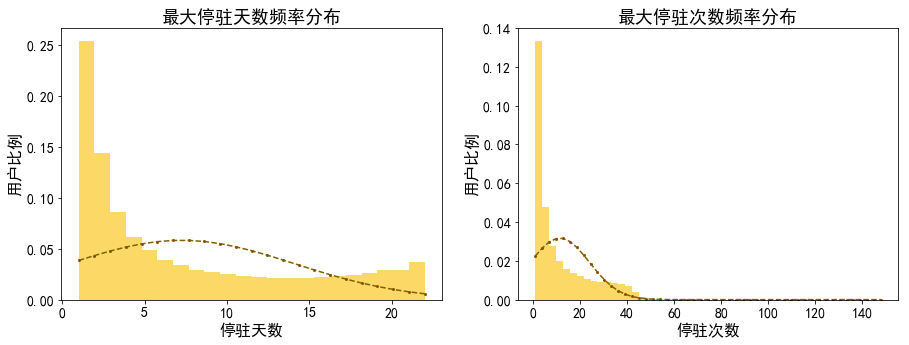

In [ ]:
# 简单的频率分布分析
import matplotlib as mpl
def plot_hist(series, num_bins, color_bins, color_line, alpha=1, label='', linestyle='dashed', marker='o', markerfacecolor='r', markersize=2): 
    # 将hist设置为函数
    # num_bins = 30
    mu, sigma = series.agg(['mean','std'])
    n, bins, patchs = plt.hist(series, num_bins, normed=1, color=color_bins, alpha=alpha,label=label)
    y = mpl.mlab.normpdf(bins,mu,sigma)
    plt.plot(bins,y,color=color_line, linestyle=linestyle, marker=marker, markerfacecolor=markerfacecolor, markersize=markersize)

    
def rgb(R,G,B): return "#%02X%02X%02X" % (R,G,B)
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
# data.iloc[:10000,:].groupby('user_id').stopNum.max().hist(bins=30)
plot_hist(data.groupby('user_id').dateNum.max(),num_bins=22,color_bins=rgb(252,216,103),color_line=rgb(123,99,0))
plt.title('最大停驻天数频率分布',fontsize=18)
plt.xlabel('停驻天数',fontsize=16)
plt.ylabel('用户比例',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
# data.iloc[:10000,:].groupby('user_id').dateNum.max().hist(bins=30)
plot_hist(data.groupby('user_id').stopNum.max(),num_bins=50,color_bins=rgb(252,216,103),color_line=rgb(123,99,0))
plt.title('最大停驻次数频率分布',fontsize=18)
plt.xlabel('停驻次数',fontsize=16)
plt.ylabel('用户比例',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('C:\\Users\Administrator\Desktop\c1.png',bbox_inches='tight',pad_inches=0,dpi=600)

#### 考虑同地规则：若工作与居住相同，则取下一个

In [ ]:
# date_max = data.groupby('user_id').dateNum.max()
# userFilter = date_max[date_max >= 10].index.tolist()  # 筛选满足停驻天数条件的用户数据
# dataFilter = data[data.user_id.isin(userFilter)]

# 识别居住与工作位置栅格,为简化计算，采用记录id的方式
t0 = datetime.datetime.now()
homeID = list()
workID = list()
for user,udata in data.groupby('user_id'):
#     print(user)
    hdata = udata[udata.th == udata.th.max()]   # 最有可能在家的停驻
    homeID.append([user, hdata.index.values[0]])# 居住
    wdata = udata[udata.tw == udata.tw.max()]   # 最有可能工作的停驻
    if len(udata)>1 and wdata[['loncol_500','latcol_500']].values.tolist() == hdata[['loncol_500','latcol_500']].values.tolist():
        wdata = udata[udata.tw == udata.tw.nlargest(2).iloc[1]]   # 第二大的停驻天数  函数df.nlargest()
        workID.append([user, wdata.index.values[0]])
    elif len(udata)>1 and wdata[['loncol_500','latcol_500']].values.tolist() != hdata[['loncol_500','latcol_500']].values.tolist():
        workID.append([user, wdata.index.values[0]])  # 1.只有一行，2.工作与家不一样
    else:
        workID.append([user,''])
print((datetime.datetime.now()-t0).seconds / 60)

In [ ]:
# pd.DataFrame(homeID).to_csv('/home_id.csv',index=False)
# pd.DataFrame(workID).to_csv('/work_id.csv',index=False)
# pd.DataFrame(homeID).to_csv('C:\\Users\\Administrator\\Desktop\\home_id.csv',index=False)`
# pd.DataFrame(workID).to_csv('C:\\Users\\Administrator\\Desktop\\work_id.csv',index=False)

# 将index转化为数据
homeID = pd.read_csv('./home_id.csv')
homeID.columns=['user_id','home_id']
home_data = data.loc[homeID.home_id.values]

workID = pd.read_csv('./work_id.csv')
workID.columns=['user_id','work_id']
workID.dropna(inplace=True)
work_data = data.loc[workID.work_id.values]

#### 不考虑同地规则

In [7]:
home_data = data[data.groupby('user_id').th.transform(max) == data.th]
work_data = data[data.groupby('user_id').tw.transform(max) == data.tw]

#### 居住工作识别结果处理

In [8]:
home_data = home_data[home_data.dateNum >= 10]
work_data = work_data[work_data.dateNum >= 10]

In [9]:
hw = pd.merge(home_data,work_data,how='outer',on='user_id',suffixes=('_h','_w'))

In [232]:
hw.head()

,user_id,loncol_500_h,latcol_500_h,stopNum_h,dateNum_h,tw_h,th_h,loncol_500_w,latcol_500_w,stopNum_w,dateNum_w,tw_w,th_w
0,9,550.0,150.0,21.0,14.0,2066.0,389978.0,NaN,NaN,NaN,NaN,NaN,NaN
1,16,571.0,116.0,23.0,13.0,189777.0,444145.0,571.0,116.0,23.0,13.0,189777.0,444145.0
2,31,562.0,160.0,26.0,19.0,3004.0,432008.0,572.0,120.0,13.0,11.0,130919.0,34530.0
3,34,591.0,146.0,38.0,20.0,0.0,746446.0,578.0,111.0,21.0,19.0,444386.0,23663.0
4,38,86.0,280.0,11.0,11.0,102081.0,52917.0,86.0,280.0,11.0,11.0,102081.0,52917.0


In [10]:
hw1 = hw[(~hw.th_h.isnull()) & (~hw.tw_w.isnull())]   # 成功识别居住与工作
hw2 = hw[(~hw.th_h.isnull()) & (hw.tw_w.isnull())]    # 成功识别居住，无法识别工作
hw3 = hw[(hw.th_h.isnull()) & (~hw.tw_w.isnull())]    # 成功识别工作，无法识别居住   
hw4 = data[data.user_id.isin(set(data.user_id.unique()) - set(hw.user_id.unique()))]  # 无法识别居住和工作

In [11]:
# 总体情况
print(data.user_id.nunique(), hw.user_id.nunique(), hw1.user_id.nunique(), hw2.user_id.nunique(), hw3.user_id.nunique(), hw4.user_id.nunique())
# 7330357 6479944 596422 253991

23726274 7330357 6479944 596422 253991 16395917


In [234]:
# 从第一类用户中筛选有用信息
hw_total = hw[['user_id','loncol_500_h','latcol_500_h','loncol_500_w','latcol_500_w']].reset_index(drop=True)

In [235]:
# 栅格转乡镇: 注意有些栅格对应对个乡镇，导致新表比旧表多
hw_totalTown_temp = hw_total.merge(grid[['LONCOL','LATCOL','name','County','City','Province','GridRing','TownRing']],how='left',\
                               left_on=['loncol_500_h','latcol_500_h'],right_on=['LONCOL','LATCOL'])
hw_totalTown_temp2 = hw_totalTown_temp.merge(grid[['LONCOL','LATCOL','name','County','City','Province','GridRing','TownRing']],how='left',\
                               left_on=['loncol_500_w','latcol_500_w'],right_on=['LONCOL','LATCOL'],suffixes=('_h', '_w'))

In [236]:
hw_total_town = hw_totalTown_temp2[['user_id','loncol_500_h','latcol_500_h','name_h','County_h','City_h','Province_h','GridRing_h','TownRing_h',\
                                    'loncol_500_w','latcol_500_w','name_w','County_w','City_w','Province_w','GridRing_w','TownRing_w']]

In [237]:
hw_total_town.head()

,user_id,loncol_500_h,latcol_500_h,name_h,County_h,City_h,Province_h,GridRing_h,TownRing_h,loncol_500_w,latcol_500_w,name_w,County_w,City_w,Province_w,GridRing_w,TownRing_w
0,9,550.0,150.0,马陆镇,嘉定区,上海市,上海市,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16,571.0,116.0,虹桥镇,闵行区,上海市,上海市,1.0,1.0,571.0,116.0,虹桥镇,闵行区,上海市,上海市,1.0,1.0
2,31,562.0,160.0,罗店镇,宝山区,上海市,上海市,0.0,0.0,572.0,120.0,仙霞新村街道,长宁区,上海市,上海市,1.0,1.0
3,34,591.0,146.0,新江湾城街道,杨浦区,上海市,上海市,1.0,1.0,578.0,111.0,漕河泾街道,徐汇区,上海市,上海市,1.0,1.0
4,38,86.0,280.0,秣陵街道,江宁区,南京市,江苏省,0.0,0.0,86.0,280.0,秣陵街道,江宁区,南京市,江苏省,0.0,0.0


In [243]:
hw_total_town[hw_total_town.City_h == '上海市'].user_id.nunique()

3145309

In [242]:
hw_total_town[(hw_total_town.City_h == '上海市') & (~hw_total_town.City_w.isnull())].user_id.nunique()

2834328

#### 居住与工作位置统计结果导入---栅格层面

In [37]:
hw1_hcnt = hw1.groupby(['loncol_500_h','latcol_500_h']).user_id.count().reset_index()
hw1_hcnt.rename(columns={'user_id':'cnt'},inplace=True)
hw1_hcnt_grid = grid.merge(hw1_hcnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_h','latcol_500_h'],how='left')
hw1_hcnt_grid.cnt.fillna(0,inplace=True)
hw1_hcnt_grid.cnt = hw1_hcnt_grid.cnt.astype(int)
hw1_hcnt_grid.to_file('../190519导出职住数据-new/ArcGIS图/hw1_homecnt.shp',encoding='gb2312')

hw1_wcnt = hw1.groupby(['loncol_500_w','latcol_500_w']).user_id.count().reset_index()
hw1_wcnt.rename(columns={'user_id':'cnt'},inplace=True)
hw1_wcnt_grid = grid.merge(hw1_wcnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_w','latcol_500_w'],how='left')
hw1_wcnt_grid.cnt.fillna(0,inplace=True)
hw1_wcnt_grid.cnt = hw1_wcnt_grid.cnt.astype(int)
hw1_wcnt_grid.to_file('../190519导出职住数据-new/ArcGIS图/hw1_workcnt.shp',encoding='gb2312')

In [38]:
hw2_cnt = hw2.groupby(['loncol_500_h','latcol_500_h']).user_id.count().reset_index()
hw2_cnt.rename(columns={'user_id':'cnt'},inplace=True)
hw2_cnt_grid = grid.merge(hw2_cnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_h','latcol_500_h'],how='left')
hw2_cnt_grid.cnt.fillna(0,inplace=True)
hw2_cnt_grid.cnt = hw2_cnt_grid.cnt.astype(int)
hw2_cnt_grid.to_file('../190519导出职住数据-new/ArcGIS图/hw2_homecnt.shp',encoding='gb2312')

hw3_cnt = hw3.groupby(['loncol_500_w','latcol_500_w']).user_id.count().reset_index()
hw3_cnt.rename(columns={'user_id':'cnt'},inplace=True)
hw3_cnt_grid = grid.merge(hw3_cnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_w','latcol_500_w'],how='left')
hw3_cnt_grid.cnt.fillna(0,inplace=True)
hw3_cnt_grid.cnt = hw3_cnt_grid.cnt.astype(int)
hw3_cnt_grid.to_file('../190519导出职住数据-new/ArcGIS图/hw3_workcnt.shp',encoding='gb2312')

#### 居住与工作位置统计结果导入---乡镇层面

In [ ]:
hw1_hcnt_town = hw1_hcnt_grid.groupby(['County','name']).cnt.sum().reset_index()
hw1_wcnt_town = hw1_wcnt_grid.groupby(['County','name']).cnt.sum().reset_index()
hw1_hcnt_townshp = town.merge(hw1_hcnt_town, on=['County','name'],how='inner')
hw1_wcnt_townshp = town.merge(hw1_wcnt_town, on=['County','name'],how='inner')

In [ ]:
hw2_cnt_town = hw2_cnt_grid.groupby(['County','name']).cnt.sum().reset_index()
hw2_cnt_townshp = town.merge(hw2_cnt_town, on=['County','name'],how='inner')
hw3_cnt_town = hw3_cnt_grid.groupby(['County','name']).cnt.sum().reset_index()
hw3_cnt_townshp = town.merge(hw3_cnt_town, on=['County','name'],how='inner')

In [ ]:
hw1_hcnt_townshp.to_file('../190519导出职住数据-new/ArcGIS图/hw1_homecnt_town.shp',encoding='gb2312')
hw1_wcnt_townshp.to_file('../190519导出职住数据-new/ArcGIS图/hw1_workcnt_town.shp',encoding='gb2312')
hw2_cnt_townshp.to_file('../190519导出职住数据-new/ArcGIS图/hw2_homecnt_town.shp',encoding='gb2312')
hw3_cnt_townshp.to_file('../190519导出职住数据-new/ArcGIS图/hw3_workcnt_town.shp',encoding='gb2312')

### (2) 对hw1进行人口分析

In [13]:
# 从第一类用户中筛选有用信息
hwBaseGrid = hw1[['user_id','loncol_500_h','latcol_500_h','loncol_500_w','latcol_500_w']].reset_index(drop=True)

In [14]:
# 栅格转乡镇: 注意有些栅格对应对个乡镇，导致新表比旧表多
hwBaseTownH = hwBaseGrid.merge(grid[['LONCOL','LATCOL','name','County','City','Province','GridRing','TownRing']],how='left',\
                               left_on=['loncol_500_h','latcol_500_h'],right_on=['LONCOL','LATCOL'])
hwBaseTownW = hwBaseTownH.merge(grid[['LONCOL','LATCOL','name','County','City','Province','GridRing','TownRing']],how='left',\
                               left_on=['loncol_500_w','latcol_500_w'],right_on=['LONCOL','LATCOL'],suffixes=('_h', '_w'))

In [15]:
hwBaseTown = hwBaseTownW[['user_id','loncol_500_h','latcol_500_h','name_h','County_h','City_h','Province_h','GridRing_h','TownRing_h',\
                                    'loncol_500_w','latcol_500_w','name_w','County_w','City_w','Province_w','GridRing_w','TownRing_w']]

In [20]:
# 栅格没有对应的乡镇
print(len(hwBaseTown[pd.isnull(hwBaseTown).any(axis=1)]))
hwBaseTown[pd.isnull(hwBaseTown).any(axis=1)].head()

799


,user_id,loncol_500_h,latcol_500_h,name_h,County_h,City_h,Province_h,GridRing_h,TownRing_h,loncol_500_w,latcol_500_w,name_w,County_w,City_w,Province_w,GridRing_w,TownRing_w
11647,55124,387.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,387.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN
13918,65889,384.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,384.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
34411,163890,366.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,366.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN
39799,189749,441.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,444.0,73.0,汾湖镇,吴江区,苏州市,江苏省,0.0,0.0
40398,192552,442.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,442.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
hwBaseTown.user_id.nunique()

6479944

In [228]:
# 城市用户量统计
hw_pop = hwBaseTown.groupby('City_h').user_id.count().reset_index().dropna()
hw_pop.rename(columns={'City_h':'city','user_id':'cnt'},inplace=True)

In [224]:
# 城市2017年人口
pop = pd.DataFrame(\
[['上海市',2418.33,18.89],\
['南京市',833.50,14.86],\
['无锡市',655.30,13.8],\
['常州市',471.73,10.94],\
['苏州市',1068.36,22.24],\
['南通市',730.50,8.17],\
['扬州市',450.82,9.42],\
['镇江市',318.63,9.44],\
['泰州市',465.19,7.02]], columns=['city','population','originRate'])

In [246]:
hw_poprate = pd.merge(hw_pop, pop, on='city')
hw_poprate['rate'] = hw_poprate.cnt / hw_poprate.population / 100
hw_poprate.sort_values('rate',ascending=False,inplace=True)
hw_poprate.reset_index(drop=True,inplace=True)

In [247]:
hw_poprate

,city,cnt,population,originRate,rate
0,上海市,2941575,2418.33,18.89,12.163663
1,苏州市,1275357,1068.36,22.24,11.937521
2,南京市,762192,833.50,14.86,9.144475
3,无锡市,496736,655.30,13.80,7.580284
4,常州市,276196,471.73,10.94,5.854959
5,镇江市,166877,318.63,9.44,5.237329
6,扬州市,214405,450.82,9.42,4.755889
7,南通市,297801,730.50,8.17,4.076674
8,泰州市,157506,465.19,7.02,3.385842


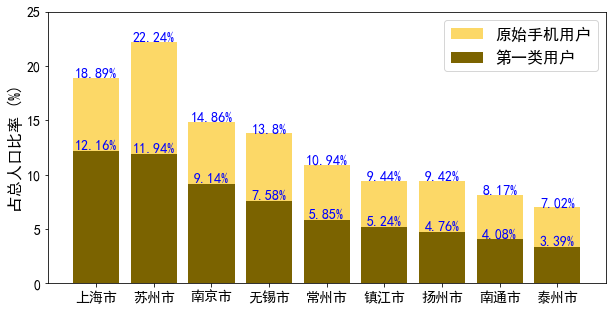

In [248]:
fig, ax = plt.subplots(figsize=(10,5))
def rgb(R,G,B): return "#%02X%02X%02X" % (R,G,B)
plt.bar(range(9),hw_poprate.originRate,color=rgb(252,216,103))
for i,v in enumerate(hw_poprate.originRate): ax.text(i,v+0.4, str(v)+'%',color='b',horizontalalignment='center',verticalalignment='center',\
                                                     fontsize=14, fontweight='bold')

plt.bar(range(9),hw_poprate.rate,color=rgb(123,99,0))
for i,v in enumerate(hw_poprate.rate): ax.text(i,v+0.5, str(round(v,2))+'%',color='b',horizontalalignment='center',verticalalignment='center',\
                                                     fontsize=14, fontweight='bold')
    
plt.xticks(range(9),hw_poprate.city.values,fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,25])
# plt.xlabel('研究范围内城市',fontsize=16)
plt.ylabel('占总人口比率 (%)',fontsize=16)
plt.legend(['原始手机用户','第一类用户'],fontsize=16)
plt.savefig('C:\\Users\Administrator\Desktop\渗透率.png',bbox_inches='tight',pad_inches=0,dpi=600)

### (3) 职住识别验证-上海用户

In [144]:
# 上海市16个区的人口,根据《上海2018年统计年鉴》,单位：万人
pop_sh = pd.DataFrame(\
[['浦东新区',552.84],\
['黄浦区',65.48],\
['徐汇区',108.83],\
['长宁区',69.37],\
['静安区',106.62],\
['普陀区',128.47],\
['虹口区',79.90],\
['杨浦区',131.34],\
['闵行区',253.43],\
['宝山区',203.08],\
['嘉定区',158.18],\
['金山区',80.14],\
['松江区',175.13],\
['青浦区',120.53],\
['奉贤区',115.53],\
['崇明区',69.46]],columns=['County','population'])

In [145]:
# 提取手机数据中居住和工作均在上海的用户
hw_SH = hwBaseTown[(hwBaseTown.City_h=='上海市') & (hwBaseTown.City_w=='上海市')]
hwSH_towncnt = hw_SH.groupby(['name_h','name_w']).user_id.count().reset_index()        # 乡镇层面
hwSH_towncnt.rename(columns={'user_id':'cnt'},inplace=True)
hwSH_countycnt = hw_SH.groupby(['County_h','County_w']).user_id.count().reset_index()  #区县层面
hwSH_countycnt.rename(columns={'user_id':'cnt'},inplace=True)

# 按区扩样
user_mobile = hwSH_countycnt.groupby('County_h').cnt.sum().reset_index()
user_expand = pd.merge(user_mobile,pop_sh,left_on='County_h',right_on='County')
user_expand['factor'] = user_expand.population / user_expand.cnt * 10000  # 扩样因子

# 扩样后的用户量
hwSH_countycnt2 = pd.merge(hwSH_countycnt, user_expand[['County_h','factor']],on='County_h')
hwSH_countycnt2['new_cnt'] = hwSH_countycnt2.cnt * hwSH_countycnt2.factor

In [146]:
# 2009年居民出行调查数据,直接用家庭行政区和单位行政区
xz_survey = pd.read_csv('E:\\zhpy\\2travel_survey_2009SH\\hw_cnt_sh.csv',encoding='gb2312')  # 已经扩样后的职住数据
county_combine = pd.merge(hwSH_countycnt2,xz_survey,left_on=['County_h','County_w'],right_on=['H_XZ','W_XZ'],suffixes=['_mobile','_hts'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text yticklabel objects>)

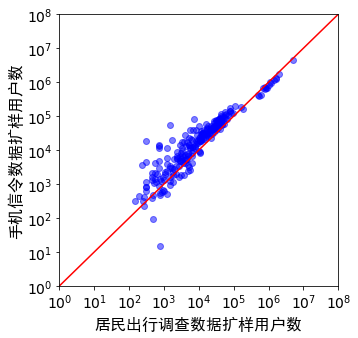

In [179]:
fig, ax = plt.subplots(figsize=(5,5))
xsh = county_combine.new_cnt_hts.values.reshape((-1,1))
ysh = county_combine.new_cnt_mobile.values.reshape((-1,1))
plt.scatter(np.log10(xsh),np.log10(ysh), marker='o', linewidths=1, c='b',alpha=0.5)
plt.plot(range(10),range(10),color='r')
plt.xlim([0,8])
plt.ylim([0,8])
# plt.title('上海职住量比较',fontsize=18)
plt.xlabel('居民出行调查数据扩样用户数',fontsize=16)
plt.ylabel('手机信令数据扩样用户数',fontsize=16)
plt.xticks(range(9),['$10^{}$'.format(x) for x in range(9)])
plt.yticks(range(9),['$10^{}$'.format(x) for x in range(9)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('C:\\Users\Administrator\Desktop\z1.png',bbox_inches='tight',pad_inches=0,dpi=600)

### (3) 职住识别验证-南京用户

In [171]:
pop_nj = pd.DataFrame(\
[['玄武区',60.02],\
['秦淮区',100.03],\
['建邺区',47.26],\
['鼓楼区',116.84],\
['浦口区',79.88],\
['栖霞区',71.79],\
['雨花台区',45.45],\
['江宁区',124.85],\
['六合区',96.35],\
['溧水区',46.39],\
['高淳区',44.64]],columns=['County','population'])

In [172]:
# 提取手机数据中居住和工作均在南京的用户
hw_NJ = hwBaseTown[(hwBaseTown.City_h=='南京市') & (hwBaseTown.City_w=='南京市')]
hwNJ_countycnt = hw_NJ.groupby(['County_h','County_w']).user_id.count().reset_index()  #区县层面
hwNJ_countycnt.rename(columns={'user_id':'cnt'},inplace=True)

In [173]:
# 按区扩样
user_mobile_nj = hwNJ_countycnt.groupby('County_h').cnt.sum().reset_index()
user_expand_nj = pd.merge(user_mobile_nj,pop_nj,left_on='County_h',right_on='County')
user_expand_nj['factor'] = user_expand_nj.population / user_expand_nj.cnt * 10000  # 扩样因子

# 扩样后的用户量
hwNJ_countycnt2 = pd.merge(hwNJ_countycnt, user_expand_nj[['County_h','factor']],on='County_h')
hwNJ_countycnt2['new_cnt'] = hwNJ_countycnt2.cnt * hwNJ_countycnt2.factor

In [174]:
# 南京居民调查数据
hwNJ_ncnt = pd.read_csv('E:\\zhpy\\2travel_survey_2009SH\\hw_cnt_nj.csv',encoding='gb2312')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text yticklabel objects>)

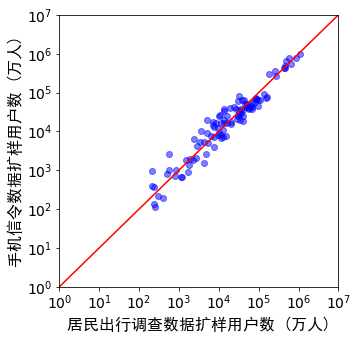

In [177]:
combine = pd.merge(hwNJ_countycnt2,hwNJ_ncnt,left_on=['County_h','County_w'],right_on=['H_XZ','W_XZ'],suffixes=['_mobile','_hts'])
fig, ax = plt.subplots(figsize=(5,5))
x = combine.new_cnt_hts.values.reshape((-1,1))
y = combine.new_cnt_mobile.values.reshape((-1,1))
plt.scatter(np.log10(x),np.log10(y), marker='o', linewidths=1, c='b',alpha=0.5)
plt.plot(range(10),range(10),color='r')
plt.xlim([0,7])
plt.ylim([0,7])
# plt.title('上海职住量比较',fontsize=18)
plt.xlabel('居民出行调查数据扩样用户数 (万人)',fontsize=16)
plt.ylabel('手机信令数据扩样用户数 (万人)',fontsize=16)
plt.xticks(range(8),['$10^{}$'.format(x) for x in range(8)])
plt.yticks(range(8),['$10^{}$'.format(x) for x in range(8)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('C:\\Users\Administrator\Desktop\z2.png',bbox_inches='tight',pad_inches=0,dpi=600)

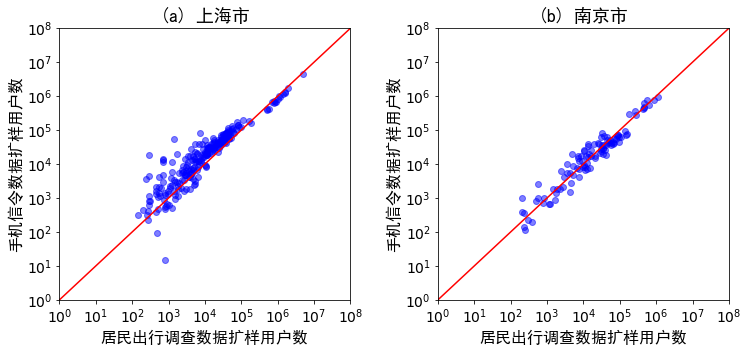

In [213]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
xsh = county_combine.new_cnt_hts.values.reshape((-1,1))
ysh = county_combine.new_cnt_mobile.values.reshape((-1,1))
plt.plot(range(10),range(10),color='r')
plt.scatter(np.log10(xsh),np.log10(ysh), marker='o', linewidths=1, c='b',alpha=0.5)

plt.xlim([0,8])
plt.ylim([0,8])
plt.title('(a) 上海市',fontsize=18)
plt.xlabel('居民出行调查数据扩样用户数',fontsize=16)
plt.ylabel('手机信令数据扩样用户数',fontsize=16)
plt.xticks(range(9),['$10^{}$'.format(x) for x in range(9)])
plt.yticks(range(9),['$10^{}$'.format(x) for x in range(9)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
combine = pd.merge(hwNJ_countycnt2,hwNJ_ncnt,left_on=['County_h','County_w'],right_on=['H_XZ','W_XZ'],suffixes=['_mobile','_hts'])
x = combine.new_cnt_hts.values.reshape((-1,1))
y = combine.new_cnt_mobile.values.reshape((-1,1))
plt.plot(range(10),range(10),color='r')
plt.scatter(np.log10(x),np.log10(y), marker='o', linewidths=1, c='b',alpha=0.5)

plt.xlim([0,8])
plt.ylim([0,8])
plt.title('(b) 南京市',fontsize=18)
plt.xlabel('居民出行调查数据扩样用户数',fontsize=16)
plt.ylabel('手机信令数据扩样用户数',fontsize=16)
plt.xticks(range(9),['$10^{}$'.format(x) for x in range(9)])
plt.yticks(range(9),['$10^{}$'.format(x) for x in range(9)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(wspace=0.3)


# plt.savefig('C:\\Users\Administrator\Desktop\z1.png',bbox_inches='tight',pad_inches=0,dpi=600)

### (4) hw1分析---上海市域、外环

In [22]:
# 799个栅格没有乡镇对应
hwBaseTown.head()

,user_id,loncol_500_h,latcol_500_h,name_h,County_h,City_h,Province_h,GridRing_h,TownRing_h,loncol_500_w,latcol_500_w,name_w,County_w,City_w,Province_w,GridRing_w,TownRing_w
0,16,571.0,116.0,虹桥镇,闵行区,上海市,上海市,1.0,1.0,571.0,116.0,虹桥镇,闵行区,上海市,上海市,1.0,1.0
1,31,562.0,160.0,罗店镇,宝山区,上海市,上海市,0.0,0.0,572.0,120.0,仙霞新村街道,长宁区,上海市,上海市,1.0,1.0
2,34,591.0,146.0,新江湾城街道,杨浦区,上海市,上海市,1.0,1.0,578.0,111.0,漕河泾街道,徐汇区,上海市,上海市,1.0,1.0
3,38,86.0,280.0,秣陵街道,江宁区,南京市,江苏省,0.0,0.0,86.0,280.0,秣陵街道,江宁区,南京市,江苏省,0.0,0.0
4,40,205.0,376.0,汤汪乡,广陵区,扬州市,江苏省,0.0,0.0,197.0,381.0,文汇街道,邗江区,扬州市,江苏省,0.0,0.0


#### $1 上海市区(外环)---栅格层面

In [24]:
# shanghai outer ring，不需要剔除空值，都有对应的栅格
shor1 = hwBaseTown[(hwBaseTown.GridRing_h ==1) & (hwBaseTown.GridRing_w == 1)]    # 在市区居住、在市区工作
shor2 = hwBaseTown[(hwBaseTown.GridRing_h ==1) & (hwBaseTown.GridRing_w == 0)]    # 在市区居住、在市区外工作
shor3 = hwBaseTown[(hwBaseTown.GridRing_h ==0) & (hwBaseTown.GridRing_w == 1)]    # 在市区外居住、在市区工作
shor4 = hwBaseTown[(hwBaseTown.GridRing_h ==0) & (hwBaseTown.GridRing_w == 0)]    # 在市区外居住、在市区外工作

In [40]:
# 内向通勤
shor3_hcnt = shor3.groupby(['loncol_500_h','latcol_500_h']).user_id.count().reset_index()
shor3_hcnt.rename(columns={'user_id':'cnt'},inplace=True)
shor3_hcnt_grid = grid.merge(shor3_hcnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_h','latcol_500_h'],how='inner')
shor3_hcnt_grid.to_file('../190622上海通勤率分析/ArcGIS图/shor3_homecnt.shp',encoding='gb2312')

shor3_wcnt = shor3.groupby(['loncol_500_w','latcol_500_w']).user_id.count().reset_index()
shor3_wcnt.rename(columns={'user_id':'cnt'},inplace=True)
shor3_wcnt_grid = grid.merge(shor3_wcnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_w','latcol_500_w'],how='inner')
shor3_wcnt_grid.to_file('../190622上海通勤率分析/ArcGIS图/shor3_workcnt.shp',encoding='gb2312')

In [42]:
# 外向通勤
shor2_hcnt = shor2.groupby(['loncol_500_h','latcol_500_h']).user_id.count().reset_index()
shor2_hcnt.rename(columns={'user_id':'cnt'},inplace=True)
shor2_hcnt_grid = grid.merge(shor2_hcnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_h','latcol_500_h'],how='inner')
shor2_hcnt_grid.to_file('../190622上海通勤率分析/ArcGIS图/shor2_homecnt.shp',encoding='gb2312')

shor2_wcnt = shor2.groupby(['loncol_500_w','latcol_500_w']).user_id.count().reset_index()
shor2_wcnt.rename(columns={'user_id':'cnt'},inplace=True)
shor2_wcnt_grid = grid.merge(shor2_wcnt,left_on=['LONCOL','LATCOL'],right_on=['loncol_500_w','latcol_500_w'],how='inner')
shor2_wcnt_grid.to_file('../190622上海通勤率分析/ArcGIS图/shor2_workcnt.shp',encoding='gb2312')

#### $2 上海市区(外环)---街道层面

In [ ]:
# shanghai outer ring town
hwBaseTown2 = hwBaseTown.dropna()    # 对于街道，先剔除栅格无对应的数据

short1 = hwBaseTown2[(hwBaseTown2.TownRing_h ==1) & (hwBaseTown2.TownRing_w == 1)]    # 在市区居住、在市区工作
short2 = hwBaseTown2[(hwBaseTown2.TownRing_h ==1) & (hwBaseTown2.TownRing_w == 0)]    # 在市区居住、在市区外工作
short3 = hwBaseTown2[(hwBaseTown2.TownRing_h ==0) & (hwBaseTown2.TownRing_w == 1)]    # 在市区外居住、在市区工作
short4 = hwBaseTown2[(hwBaseTown2.TownRing_h ==0) & (hwBaseTown2.TownRing_w == 0)]    # 在市区外居住、在市区外工作

# 内向通勤
short3_hcnt = short3.groupby(['name_h','County_h']).user_id.count().reset_index()
short3_hcnt.rename(columns={'user_id':'cnt'},inplace=True)
short3_hcnt_town = town.merge(short3_hcnt,left_on=['name','County'],right_on=['name_h','County_h'],how='inner')
short3_hcnt_town.to_file('../190622上海通勤率分析/ArcGIS图/short3_homecnt_town.shp',encoding='gb2312')

# 外向通勤
short2_wcnt = short2.groupby(['name_w','County_w']).user_id.count().reset_index()
short2_wcnt.rename(columns={'user_id':'cnt'},inplace=True)
short2_wcnt = pd.merge(short2_wcnt,pop_town_sh,left_on=['name_w','County_w'],right_on=['name','County'],how='inner')
short2_wcnt['rate'] = short2_wcnt.cnt / short2_wcnt.population
short2_wcnt_town = town.merge(short2_wcnt[['name_w','County_w','rate']],left_on=['name','County'],right_on=['name_w','County_w'],how='inner')
short2_wcnt_town.to_file('../190622上海通勤率分析/ArcGIS图/short2_workcnt_town.shp',encoding='gb2312')

In [117]:
hwBaseTown2 = hwBaseTown.dropna()    # 对于街道，先剔除栅格无对应的数据

# 上海乡镇街道人口，columns=['County', 'name', 'population']
pop_town_sh = pd.read_csv('../0基础数据/上海乡镇人口数据.csv',encoding='gb2312')

# 扩样
hw1_town_user = hwBaseTown2.groupby(['County_h','name_h']).user_id.count().reset_index()
hw1_town_user.rename(columns={'user_id':'user_num'},inplace=True)
hw1_town_user = pd.merge(hw1_town_user,pop_town_sh,left_on=['County_h','name_h'],right_on=['County','name'],how='left')
hwBaseTown2 = pd.merge(hwBaseTown2,hw1_town_user,on=['County_h','name_h'],how='left')
hwBaseTown2['expand'] = hwBaseTown2.population / hwBaseTown2.user_num

short1 = hwBaseTown2[(hwBaseTown2.TownRing_h ==1) & (hwBaseTown2.TownRing_w == 1)]    # 在市区居住、在市区工作
short2 = hwBaseTown2[(hwBaseTown2.TownRing_h ==1) & (hwBaseTown2.TownRing_w == 0)]    # 在市区居住、在市区外工作
short3 = hwBaseTown2[(hwBaseTown2.TownRing_h ==0) & (hwBaseTown2.TownRing_w == 1)]    # 在市区外居住、在市区工作
short4 = hwBaseTown2[(hwBaseTown2.TownRing_h ==0) & (hwBaseTown2.TownRing_w == 0)]    # 在市区外居住、在市区外工作

# 内向通勤
short3_hcnt = short3.groupby(['name_h','County_h']).expand.sum().reset_index()
short3_hcnt.rename(columns={'expand':'cnt'},inplace=True)
short3_hcnt = pd.merge(short3_hcnt,pop_town_sh,left_on=['name_h','County_h'],right_on=['name','County'],how='inner')
short3_hcnt['rate'] = short3_hcnt.cnt / short3_hcnt.population
short3_hcnt_town = town.merge(short3_hcnt[['name_h','County_h','rate']],left_on=['name','County'],right_on=['name_h','County_h'],how='inner')
short3_hcnt_town.to_file('../190622上海通勤率分析/ArcGIS图-扩样/short3_homecnt_town.shp',encoding='gb2312')

# 外向通勤
short2_wcnt = short2.groupby(['name_w','County_w']).expand.sum().reset_index()
short2_wcnt.rename(columns={'expand':'cnt'},inplace=True)
short2_wcnt = pd.merge(short2_wcnt,pop_town_sh,left_on=['name_w','County_w'],right_on=['name','County'],how='inner')
short2_wcnt['rate'] = short2_wcnt.cnt / short2_wcnt.population
short2_wcnt_town = town.merge(short2_wcnt[['name_w','County_w','rate']],left_on=['name','County'],right_on=['name_w','County_w'],how='inner')
short2_wcnt_town.to_file('../190622上海通勤率分析/ArcGIS图-扩样/short2_workcnt_town.shp',encoding='gb2312')

In [118]:
hwBaseTown.head()

,user_id,loncol_500_h,latcol_500_h,name_h,County_h,City_h,Province_h,GridRing_h,TownRing_h,loncol_500_w,latcol_500_w,name_w,County_w,City_w,Province_w,GridRing_w,TownRing_w
0,16,571.0,116.0,虹桥镇,闵行区,上海市,上海市,1.0,1.0,571.0,116.0,虹桥镇,闵行区,上海市,上海市,1.0,1.0
1,31,562.0,160.0,罗店镇,宝山区,上海市,上海市,0.0,0.0,572.0,120.0,仙霞新村街道,长宁区,上海市,上海市,1.0,1.0
2,34,591.0,146.0,新江湾城街道,杨浦区,上海市,上海市,1.0,1.0,578.0,111.0,漕河泾街道,徐汇区,上海市,上海市,1.0,1.0
3,38,86.0,280.0,秣陵街道,江宁区,南京市,江苏省,0.0,0.0,86.0,280.0,秣陵街道,江宁区,南京市,江苏省,0.0,0.0
4,40,205.0,376.0,汤汪乡,广陵区,扬州市,江苏省,0.0,0.0,197.0,381.0,文汇街道,邗江区,扬州市,江苏省,0.0,0.0


In [61]:
hsh

City_w
上海市    2846531
苏州市      13555
南通市        772
无锡市        256
南京市        130
常州市         79
泰州市         54
镇江市         22
扬州市         22
Name: user_id, dtype: int64

In [59]:
hsh = hwBaseTown[hwBaseTown.City_h == '上海市'].groupby('City_w').count().user_id.sort_values(ascending=False)
wsh = hwBaseTown[hwBaseTown.City_w == '上海市'].groupby('City_h').count().user_id.sort_values(ascending=False)

In [67]:
wsh

City_h
上海市    2846531
苏州市      13950
南通市       2477
无锡市        231
南京市        104
常州市         59
镇江市         24
泰州市         19
扬州市         19
Name: user_id, dtype: int64

#### 上海市域---栅格层面

In [142]:
pd.DataFrame(grid.drop(columns='geometry')).to_csv('C:\\Users\\Administrator\\Desktop\\grid_town.csv',encoding='gbk',index=False)